## Gradient Boosting

In [1]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

# импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, cross_val_score, learning_curve,
                                     validation_curve, RandomizedSearchCV)
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, plot_roc_curve
from tqdm import tqdm

In [2]:
# настройки отображения строк и столбцов в пандас
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

# настройка стиля графиков
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# читаем данные
df = pd.read_csv('./data/Telco-Customer-Churn.csv')

# выведу для проверки
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# в данных есть странные пропуски- пустая строка

rows_to_drop = df[df['TotalCharges']==" "].index
df.drop(rows_to_drop, axis=0, inplace=True)

In [5]:
# выведу долю пропусков по столбцам

def missing_values(data):
    """
    Возвращает колонки с пропусками(если есть):
    - общее число пропущенных значений
    - доля пропусков
    """
    missing = pd.DataFrame(df.isnull().sum())
    missing['% of Total Values'] = 100 * df.isnull().sum() / len(df)
    missing.rename(columns = {0 : 'Missing Values'}, inplace=True)
    missing.sort_values(by='% of Total Values', ascending=False, inplace=True)
    missing = missing[missing['Missing Values']>0]
    
    if missing.shape[0] == 0:
        print('В данных нет пропусков!')
    else:
        return missing

missing_values(df)

В данных нет пропусков!


## Подготовка данных

In [6]:
# закодирую целевую перменную
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# приведу признак total charges к числовому типу
df['TotalCharges'] = df['TotalCharges'].astype('float')

# удалю идентификатор клиента
df.drop('customerID', axis=1, inplace=True)

# категориальные переменные
cat_features = df.columns[df.dtypes == 'object']

# OHE для категориальных переменных
df = pd.get_dummies(df, columns=cat_features)

print(f'Размерность датасета с OHE: {df.shape}')

Размерность датасета с OHE: (7032, 46)


In [7]:
# отделю таргет и признаки
X = df.drop('Churn', axis=1)
y = df['Churn']

# воспроизводимость
rs = np.random.seed(0)
    
# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rs, stratify=y)
       
print('Доля положительных примеров в трейне: {:.4f}'.format(np.mean(y_train)), end='\n\n')
print('Доля положительных примеров в тесте: {:.4f}'.format(np.mean(y_test)))

Доля положительных примеров в трейне: 0.2657

Доля положительных примеров в тесте: 0.2659


In [8]:
# стандартизация данных
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Обучение моделей

In [9]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    print('Среднее значение \033[1m{}\033[0m для {} на валидации: \033[1m{:.4f}\033[0m'.format(
        scoring, clf_name, np.mean(cv_scores)))
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test, metric=accuracy_score):
    # название модели для красивого вывода
    clf_name = str(classifier)
    try:
        clf_name = clf_name[:clf_name.index('(')]
    except ValueError:
        pass
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [10]:
# случайный лес 

rf = RandomForestClassifier(random_state=rs)

cross_validation(rf, X_train, y_train, cv=5, scoring='roc_auc')
fit_evaluate(rf, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для RandomForestClassifier на валидации: 0.8222
Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.8236


In [11]:
# градиентный бустинг

lgbm = LGBMClassifier(random_state=rs)

cross_validation(lgbm, X_train, y_train, cv=5, scoring='roc_auc')
fit_evaluate(lgbm, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для LGBMClassifier на валидации: 0.8274
Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.8362


## Подбор гиперпараметров для градиентного бустинга

Подбирать буду стандартный набор признаков, характерный для моделей, основанных на деревьях решений:

- количество деревьев - n_estimators
- максимальная глубина дерева - max_depth
- минимальное число элементов в листе - min_data_in_leaf
- максимальное количество листьев в дереве num_leaves
- минимальное число объектов для разбиения min_child_samples
- вес класса - class_weight
- learning_rate


Подбирать буду с помощью RandomizedSearchCV

In [12]:
%%time

# пройду по широкой сетке параметров
lgbm_params = {
    'n_estimators': np.linspace(10, 2000, 1000, dtype=int),
    'max_depth': np.arange(1,20),
    'min_data_in_leaf': np.arange(1, 100),
    'num_leaves': [10, 50, 100, 150, 200, 300, 500, 750, 1000],
    'min_child_samples': np.arange(5, 50),
    'class_weight': ['balanced', None],
    'learning_rate':np.arange(0.01, 1)
}


lgbm_grid = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=rs),
    scoring='roc_auc',
    param_distributions=lgbm_params,
    cv=5,
    n_jobs=-1,
    random_state=rs,
    n_iter=3000
)

lgbm_grid.fit(X_train, y_train)
final_lgbm = lgbm_grid.best_estimator_

fit_evaluate(final_lgbm, X_train, X_test,
             y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.8484
CPU times: user 2min 20s, sys: 9.77 s, total: 2min 30s
Wall time: 38min 34s


In [13]:
# выведу classification report для LGBM

prediction_labels = final_lgbm.predict(X_test)

print(classification_report(y_test, prediction_labels))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1549
           1       0.68      0.51      0.58       561

    accuracy                           0.81      2110
   macro avg       0.76      0.71      0.73      2110
weighted avg       0.80      0.81      0.80      2110



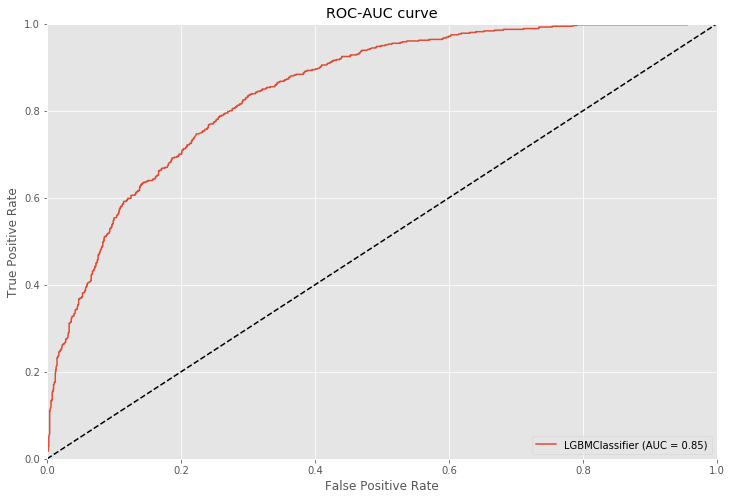

In [14]:
# roc кривая для lgbm

plot_roc_curve(final_lgbm, X_test, y_test)
plt.title('ROC-AUC curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

## Кривые обучения и валидации

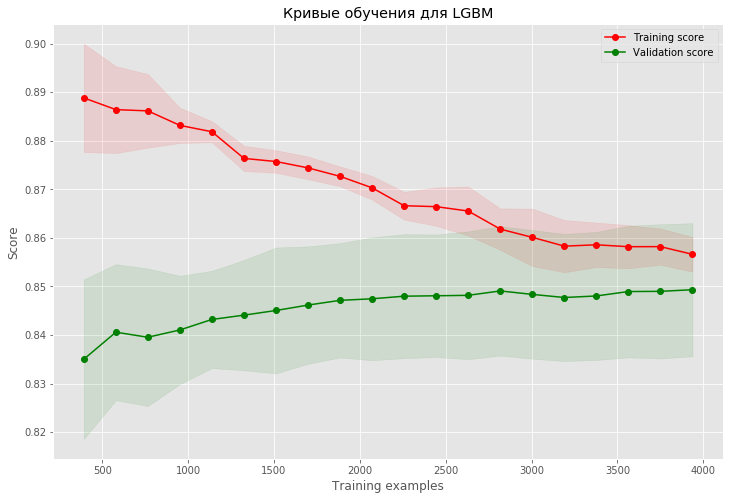

In [15]:
# построю кривые обучения

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Validation score')

    plt.legend(loc="best")
    return plt


plot_learning_curve(final_lgbm, 'Кривые обучения для LGBM', X_train, y_train, cv=5, n_jobs=-1);

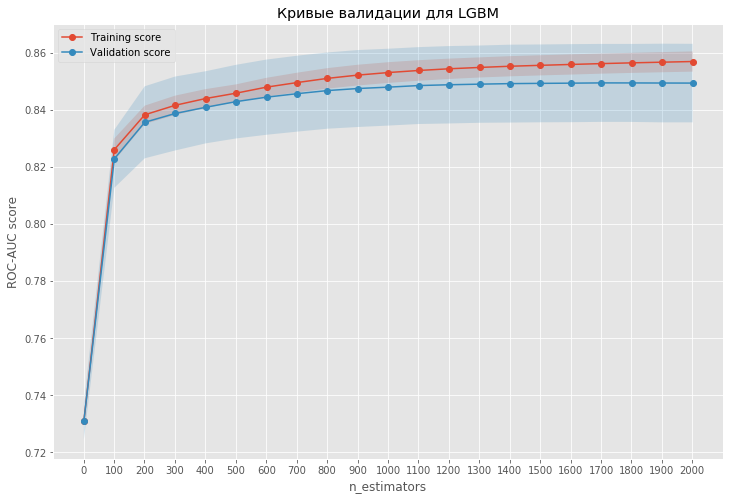

In [16]:
# построю кривые валидации

def plot_with_err(param, data, **kwargs):
    """
    Строит кривые валидации
    """
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(param, mu, 'o-', **kwargs)
    plt.fill_between(param, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
    
n_estimators = np.arange(1, 2050, 100)
val_train, val_test = validation_curve(final_lgbm, X_train, y_train,
                                       'n_estimators', n_estimators, cv=5,
                                        scoring='roc_auc')


plot_with_err(n_estimators, val_train, label='Training score')
plot_with_err(n_estimators, val_test, label='Validation score')
plt.xlabel('n_estimators'); plt.ylabel('ROC-AUC score')
plt.xticks(np.arange(0, 2050, 100))
plt.title('Кривые валидации для LGBM')
plt.legend();

## Отбор признаков

Отбор признаков простым перебором.

In [17]:
def feature_selector(estimator, X_train, X_test, y_train, y_test):
    """
    Simple feature selector
    :param estimator: sklearn like eatimator
    :param X_train: pandas DataFrame
    :param X_test: pandas DataFrame
    :param y_train: pandas Series
    :param y_test: pandas Series
    """
    # формируем список признаков
    features = list(X_train.columns)
    estimator.fit(X_train, y_train)
    preds = estimator.predict_proba(X_test)[:, 1]
    
    # сохраняем результат на всех фичах
    best_score = roc_auc_score(y_test, preds)
    
    best_features = features.copy()
    for column in tqdm(features):
        if column in best_features:
            best_features.remove(column)
            estimator.fit(X_train[best_features], y_train)
            preds = estimator.predict_proba(X_test[best_features])[:, 1]
            score = roc_auc_score(y_test, preds)
            
            # если результат ухудшился, возвращаем признак в список
            if score < best_score:
                best_features.append(column)
            else:
                best_score = score
    print(f'Best score is {best_score:.4f}')
    
    return estimator, best_features

In [18]:
# приведем признаки обратно к пандас для удобства работы с признаками
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

best_logit, best_features = feature_selector(final_lgbm, X_train, X_test, y_train, y_test)

100%|██████████| 45/45 [00:31<00:00,  1.45it/s]

Best score is 0.8504


Благодаря подбору признаков результат улучшился.